Cross-Validation R² Score: 0.99 ± 0.00
Mean Squared Error: 550.1916974397008
R² Score: 99.62%


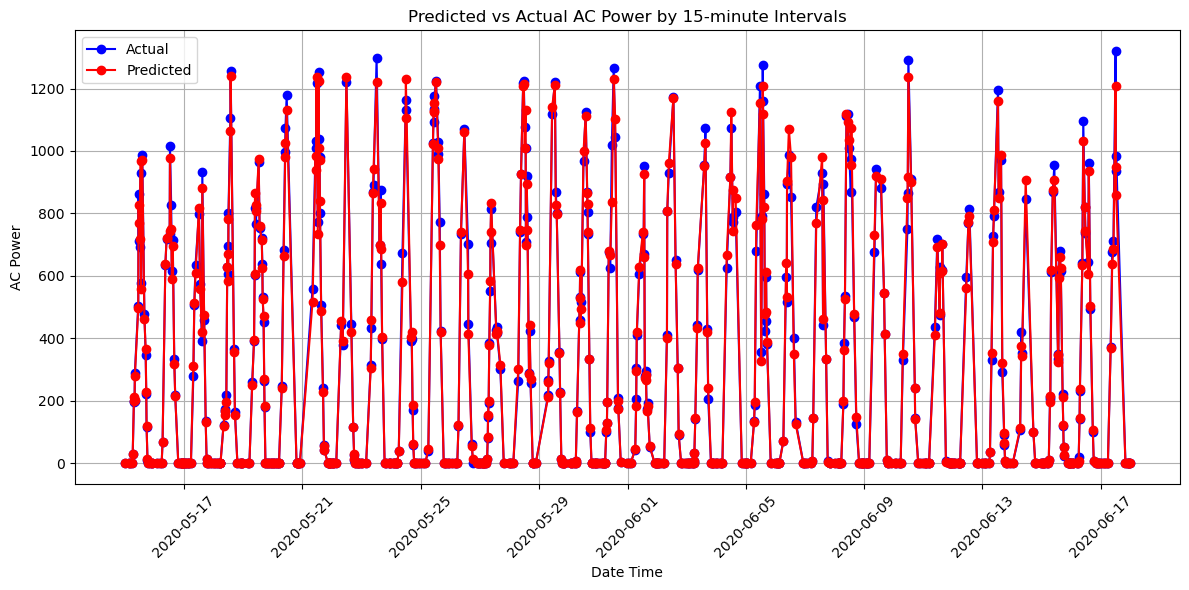

             DATE_TIME  PREDICTED_AC_POWER
0  2020-06-17 23:45:00          200.291272
1  2020-06-18 00:45:00            0.000000
2  2020-06-18 01:45:00          143.299270
3  2020-06-18 02:45:00            0.000000
4  2020-06-18 03:45:00            0.000000
5  2020-06-18 04:45:00           43.310606
6  2020-06-18 05:45:00            0.000000
7  2020-06-18 06:45:00            0.000000
8  2020-06-18 07:45:00            0.000000
9  2020-06-18 08:45:00          151.255500
10 2020-06-18 09:45:00           66.960808
11 2020-06-18 10:45:00          272.396249
12 2020-06-18 11:45:00            0.000000
13 2020-06-18 12:45:00            0.000000
14 2020-06-18 13:45:00            1.846682
15 2020-06-18 14:45:00            0.000000
16 2020-06-18 15:45:00           44.250931
17 2020-06-18 16:45:00           82.208442
18 2020-06-18 17:45:00            0.000000
19 2020-06-18 18:45:00            0.000000
20 2020-06-18 19:45:00            0.000000
21 2020-06-18 20:45:00           75.934442
22 2020-06-

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def create_features(df):
    df['HOUR'] = df['DATE_TIME'].dt.hour
    df['MINUTE'] = df['DATE_TIME'].dt.minute
    return df

p1_generate = pd.read_csv('./data/Plant_1_Generation_Data.csv')
p1_weather = pd.read_csv('./data/Plant_1_Weather_Sensor_Data.csv')

p1_generate['DATE_TIME'] = pd.to_datetime(p1_generate['DATE_TIME'], format='%d-%m-%Y %H:%M')
p1_weather['DATE_TIME'] = pd.to_datetime(p1_weather['DATE_TIME'])

plant1_data = pd.merge(p1_generate, p1_weather, on='DATE_TIME')

numeric_columns = plant1_data.select_dtypes(include=[np.number]).columns
plant1_data = plant1_data[['DATE_TIME'] + list(numeric_columns)]

plant1_data['DATE_TIME'] = plant1_data['DATE_TIME'].dt.floor('15min')

aggregated_data = plant1_data.groupby('DATE_TIME').mean().reset_index()

aggregated_data = create_features(aggregated_data)

features = ['HOUR', 'MINUTE', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
target = 'AC_POWER'

X = aggregated_data[features]
y = aggregated_data[target]

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f'Cross-Validation R² Score: {cv_mean:.2f} ± {cv_std:.2f}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model.fit(X_train, y_train)

y_test_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2 * 100:.2f}%')

X_test_df = pd.DataFrame(X_test, columns=features)
X_test_df['DATE_TIME'] = aggregated_data.loc[X_test_df.index, 'DATE_TIME']

y_test_pred = pd.Series(y_test_pred, index=X_test_df.index)

actual_values = y_test
predicted_values = y_test_pred

results = pd.DataFrame({
    'DATE_TIME': X_test_df['DATE_TIME'],
    'Actual': actual_values,
    'Predicted': predicted_values
})

results = results.sort_values(by='DATE_TIME')

plt.figure(figsize=(12, 6))
plt.plot(results['DATE_TIME'], results['Actual'], marker='o', linestyle='-', color='b', label='Actual')
plt.plot(results['DATE_TIME'], results['Predicted'], marker='o', linestyle='-', color='r', label='Predicted')
plt.title('Predicted vs Actual AC Power by 15-minute Intervals')
plt.xlabel('Date Time')
plt.ylabel('AC Power')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

future_dates = pd.date_range(start=aggregated_data['DATE_TIME'].max(), periods=48, freq='h')
future_data = pd.DataFrame(future_dates, columns=['DATE_TIME'])
future_data = create_features(future_data)

last_weather_conditions = aggregated_data[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']].iloc[-1]
future_data['AMBIENT_TEMPERATURE'] = last_weather_conditions['AMBIENT_TEMPERATURE'] + np.random.normal(0, 1, len(future_data))
future_data['MODULE_TEMPERATURE'] = last_weather_conditions['MODULE_TEMPERATURE'] + np.random.normal(0, 1, len(future_data))
future_data['IRRADIATION'] = last_weather_conditions['IRRADIATION'] + np.random.normal(0, 0.1, len(future_data))

future_data['AMBIENT_TEMPERATURE'] = np.clip(future_data['AMBIENT_TEMPERATURE'], plant1_data['AMBIENT_TEMPERATURE'].min(), plant1_data['AMBIENT_TEMPERATURE'].max())
future_data['MODULE_TEMPERATURE'] = np.clip(future_data['MODULE_TEMPERATURE'], plant1_data['MODULE_TEMPERATURE'].min(), plant1_data['MODULE_TEMPERATURE'].max())
future_data['IRRADIATION'] = np.clip(future_data['IRRADIATION'], plant1_data['IRRADIATION'].min(), plant1_data['IRRADIATION'].max())

prev_day_ac_power = aggregated_data['AC_POWER'].iloc[-24:].values
future_data['PREV_DAY_AC_POWER'] = [0]*24 + list(prev_day_ac_power)
future_predictions = rf_model.predict(future_data[features])

future_data['PREDICTED_AC_POWER'] = future_predictions
print(future_data[['DATE_TIME', 'PREDICTED_AC_POWER']])

